In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Import refGene file (transcripts table)

In [2]:
refGene = pd.read_csv('refGene.txt', sep='\t', header=None, usecols=[1,2,3,4,5,12], 
                names=['transcript','chr','strand','txStart','txEnd','gene']).sort_values('gene').reset_index(drop=True)

refGene

,transcript,chr,strand,txStart,txEnd,gene
0,NR_038165,chr7,-,45567794,45575176,0610005C13Rik
1,NR_038166,chr7,-,45567794,45575176,0610005C13Rik
2,NM_025319,chr11,-,51685384,51688634,0610009B22Rik
3,NR_152208,chr2,+,26445923,26457995,0610009E02Rik
4,NR_152209,chr2,+,26445923,26459381,0610009E02Rik
...,...,...,...,...,...,...
47377,NM_001346655,chr3,+,152395472,152462826,Zzz3
47378,NM_001080755,chr3,+,152396002,152462826,Zzz3
47379,NM_001287139,chr3,+,152396683,152462826,Zzz3
47380,NM_015770,chr2,+,155013569,155051012,a


### Filter out genes in chr_xx_random and small nc-RNAs

In [3]:
refGene = refGene[~refGene['chr'].str.contains('_')]
refGene.shape[0]

47248

In [4]:
# Patterns to exclude
patterns = ('Snord', 'Mir', 'Smarc')
refGene = refGene[~refGene['gene'].str.startswith(patterns)]
refGene.shape[0]

45780

### Generate the custom bed file with each row corresponding to unique tss per gene

In [5]:
df = refGene[['gene','chr']].copy()
df['tss'] = refGene.apply(lambda row: row['txStart'] if row['strand'] == '+' else row['txEnd'], axis=1)
df

,gene,chr,tss
0,0610005C13Rik,chr7,45575176
1,0610005C13Rik,chr7,45575176
2,0610009B22Rik,chr11,51688634
3,0610009E02Rik,chr2,26445923
4,0610009E02Rik,chr2,26445923
...,...,...,...
47377,Zzz3,chr3,152395472
47378,Zzz3,chr3,152396002
47379,Zzz3,chr3,152396683
47380,a,chr2,155013569


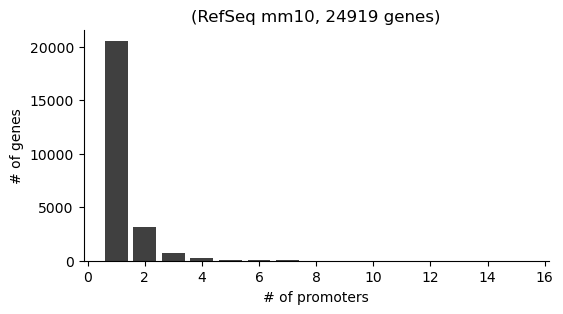

In [8]:
unique_tss_counts = df.groupby('gene')['tss'].nunique().reset_index()
plt.figure(figsize=(6,3))
sns.histplot(unique_tss_counts['tss'],discrete=True, linewidth= 0, shrink=0.8, color='black')
plt.title(f'(RefSeq mm10, {unique_tss_counts.shape[0]} genes)')
plt.xlabel('# of promoters')
plt.ylabel('# of genes')
sns.despine()
plt.savefig(f'./num_promoters_per_gene.pdf', format="pdf", bbox_inches="tight")

In [116]:
df = df.drop_duplicates(subset=['gene', 'tss'])
df

,gene,chr,tss
0,0610005C13Rik,chr7,45575176
2,0610009B22Rik,chr11,51688634
3,0610009E02Rik,chr2,26445923
6,0610009L18Rik,chr11,120348677
7,0610010F05Rik,chr11,23633631
...,...,...,...
47376,Zzz3,chr3,152396002
47377,Zzz3,chr3,152395472
47379,Zzz3,chr3,152396683
47380,a,chr2,155013569


In [117]:
DISTANCE = 2500
df = df.assign( start=df['tss'] - DISTANCE, 
                end=df['tss']   + DISTANCE)
df.sort_values('gene',inplace=True)
# Initialize variables to track counts
current_gene = ''
gene_count = 0
# List to store new_gene_name values
new_gene_names = []
# Iterate through the DataFrame
for gene in df['gene']:
    if gene == current_gene:
        gene_count += 1
    else:
        current_gene = gene
        gene_count = 1
    new_gene_names.append(f"{gene}:{gene_count}")
# Assign the new_gene_name column to the DataFrame
df['new_gene_name'] = new_gene_names
df
my_bed = df.drop(columns=['gene','tss']).copy()
my_bed.to_csv(f'refGene_promoters_{DISTANCE}.bed', sep='\t', header=False, index=False)